In [1]:
from DLtools.Trial_evaluation_rec import record_list_result
from DLtools.Data import instant_data,station_sel
from DLtools.feature_sel import call_mar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
import pywt
np.random.seed(42)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #ignore cuDNN log

/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/song/anaconda3/envs/tf-gpu-c

In [2]:
############# Keras ###################
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
##--------------------------- SETTING AREA ------------------------------##
loading = instant_data()
df,mode = loading.hourly_instant(),'hour'
# df,mode = loading.daily_instant(),'day'
if mode =='hour': n_past,n_future = 24*7,72
elif mode =='day': n_past,n_future = 60,30
st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)

In [4]:
#------------ DL PARAMETER ---------------------#
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=2)
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-5 * 0.90 ** x)
callbacks = [callback_early_stopping,reduce_lr]
my_optimizer = SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True)

In [5]:
#--------------------------- 2 Yr Edit -----------------------------------#
#host_path = './CPY012/2Yr_flood/'
#start_p = '2016-01-01'
#split_date = '2017-05-10'
#stop_p = '2018-01-01'
#n_pca = 7

In [5]:
#-----------------------Baseline / Hybrid -----------------------------------#
save_path =host_path+'trial'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [7]:
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df
def split_series(series, n_past, n_future):
    # n_past ==> no of past observations
    # n_future ==> no of future observations 
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)
def split_xy(data,n_past,n_future):
    x,y = split_series(data.values,n_past,n_future)
    x = x.reshape((x.shape[0], x.shape[1],n_features))
    y = y[:,:,0]
    return x,y

In [8]:
# ##--------------added Wavelet dwt Array ---------------##
# # coeffs = pywt.wavedecn(d_test[:92], wavelet='db')
# # arr, coeff_slices = pywt.coeffs_to_array(coeffs)
# # coeffs_from_arr = pywt.array_to_coeffs(arr, coeff_slices,output_format='wavedecn')
# # cam_recon = pywt.waverecn(coeffs_from_arr, wavelet='db2')
# #Wave  Split XY
# def DWT_seq_tran(signal2d):
#     N,M = np.zeros(signal2d.shape),np.zeros(signal2d.shape)
#     N[:,:] = signal2d[:,:]
#     for i in range(signal2d.shape[1]):
#         coeff = pywt.wavedecn(signal2d[:,i],wavelet='db4') 
#         arr, coeff_slices, coeff_shapes = pywt.ravel_coeffs(coeffs)
#         # coeff = pywt.dwt(past[:,i],wavelet='db4') #NOTE: exp2 change to dwt
#         N[:,i] =  arr
#     return N,coeff_slices, coeff_shapes

# # def call_dwt(singal):
# #     coeffs = pywt.wavedecn(singal, wavelet='db4')
# #     arr, coeff_slices, coeff_shapes = pywt.ravel_coeffs(coeffs)
# #     return arr, coeff_slices, coeff_shapes

# def dwt_split_series(series, n_past, n_future):
#     # n_past ==> no of past observations
#     # n_future ==> no of future observations 
#     X, y = list(), list()
#     for window_start in range(len(series)):
#         past_end = window_start + n_past
#         future_end = past_end + n_future
#         if future_end > len(series):
#             break
#         # slicing the past and future parts of the window
#         past, future = series[window_start:past_end, :], series[past_end:future_end, :]
#         cx,_,_ = DWT_seq_tran(past)
#         cy,_,_ = DWT_seq_tran(future)

#         X.append(cx)
#         y.append(cy)
#     return np.array(X), np.array(y)

# def dwt_split_xy(data,n_past,n_future):
#     x,y = dwt_split_series(data.values,n_past,n_future)
#     x = x.reshape((x.shape[0], x.shape[1],n_features))
#     y = y[:,:,0]
#     return x,y


In [9]:
#------------------------- Main ---------------------------------#
df = df[start_p:stop_p]
data = df
data['Day'] = data.index.dayofyear #add day
data = data.interpolate(limit=300000000,limit_direction='both').astype('float32')#interpolate neighbor first, for rest NA fill with mean() #.apply(lambda x: x.fillna(x.mean()),axis=0)

cutoff=.3
data_mar = call_mar(data,target,mode,cutoff=cutoff)
data_mar = move_column_inplace(data_mar,target,0)
n_features = len(data_mar.columns)

In [10]:
##----------- SCALE
def Preprocess_pca(input):
    
    pipe = Pipeline([('scaler', StandardScaler())])#, ('pca',PCA(n_components =n_pca))])
    scaler = pipe.fit(input)
    sc_input = pipe.transform(input)
    sc_input = pd.DataFrame(sc_input, index=input.index)
    return scaler,sc_input

# X data
_,sc_data = Preprocess_pca(data_mar)
# Y data
scaler_tar = MinMaxScaler()
scaler_tar.fit(data_mar[target].to_numpy().reshape(-1,1))
data_mar[target] = scaler_tar.transform(data_mar[target].to_numpy().reshape(-1,1))


/home/song/anaconda3/envs/tf-gpu-cuda8/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [11]:
##--- train test split 
sc_train,sc_test = sc_data[:split_date],sc_data[split_date:]
train,test = data_mar[:split_date],data_mar[split_date:]

##--------- Keep original
_, y_train = split_xy(train,n_past,n_future)
_, y_test = split_xy(test,n_past,n_future)
##--------- Wavelet_traintest
# n_features=n_pca
#cAxTrain,cDxTrain,cAyTrain,cDyTrain = SWTsplit_xy(sc_train,n_past,n_future)
#cAxTest,cDxTest,cAyTest,cDyTest = SWTsplit_xy(sc_test,n_past,n_future)


In [12]:
#----------------- minmax scale for Deeplearning 
def flatten(X):
    '''
    Flatten a 3D array.
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.   
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)
def scale(X, scaler):
    '''
    Scale 3D array.
    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])                    
    return X
# scaler = MinMaxScaler().fit(flatten(cAxTrain))
# cAX_train = scale(cAxTrain, scaler)
# scaler = MinMaxScaler().fit(flatten(cDxTrain))
# cDX_train = scale(cDxTrain, scaler)
# scaler = MinMaxScaler().fit(flatten(cAxTest))
# cAX_test = scale(cAxTest, scaler)
# scaler = MinMaxScaler().fit(flatten(cDxTest))
# cDX_test = scale(cDxTest, scaler)


In [13]:
# cX_train = [cAxTrain,cDxTrain]
# cX_test = [cAxTest,cDxTest]
# cy_train = [cAyTrain,cDyTrain]
# cy_test = [cAyTest,cDyTest]

In [14]:
def wavelet_t(series,std):
    name = series.name
    idx = series.index
    signal = series.values
    if std: signal = (signal - signal.mean())/(signal.std())

    coeff = pywt.swt(signal,'db4',level=3)
    coeff = np.array(coeff)

    cA3,cD3 = coeff[0][0],coeff[0][1]
    _,cD2 = coeff[1][0],coeff[1][1]
    _,cD1 = coeff[2][0],coeff[2][1]
    #----------------------------
    dict_data = {
            '{}_cA3'.format(name): cA3,
            '{}_cD3'.format(name): cD3,
            '{}_cD2'.format(name): cD2,
            '{}_cD1'.format(name): cD1}
    wt = pd.DataFrame(dict_data,dtype='float32',index=idx)
    return wt
def df_wavelet(df,std):
    wav_df = pd.DataFrame()
    for col in df:
        a = wavelet_t(df[col],std)
        wav_df = pd.concat([wav_df,a],axis=1)
    return wav_df
    

In [32]:
data_mar.head()

,CPY012_wl,DNP028_press,PIN004_wl,BKK021_wl,WAN005_wl,WAN003_wl,BKK013_wl,NAN009_wl,YOM012_wl,CPY006_wl
date,,,,,,,,,,
2016-01-01 00:00:00,0.345987,943.219971,40.238335,1.070000,231.529999,171.809998,1.490000,179.360001,45.633335,3.575000
2016-01-01 01:00:00,0.325741,943.219971,40.221668,1.070000,231.533340,171.808334,1.490000,179.360001,45.619999,3.556667
2016-01-01 02:00:00,0.299349,943.219971,40.206665,1.068333,231.538330,171.801666,1.493333,179.360001,45.610001,3.560000
2016-01-01 03:00:00,0.270065,943.219971,40.243332,1.060000,231.536667,171.800003,1.500000,179.360001,45.598331,3.560000
2016-01-01 04:00:00,0.242950,942.140015,40.256668,1.060000,231.535004,171.800003,1.500000,179.360001,45.588333,3.566667


In [33]:
wdata = df_wavelet(data_mar,False)
#-------------Scale minmax
scaler = MinMaxScaler()
wdata[wdata.columns] = scaler.fit_transform(wdata[wdata.columns])

wdata.head()

,CPY012_wl_cA3,CPY012_wl_cD3,CPY012_wl_cD2,CPY012_wl_cD1,DNP028_press_cA3,DNP028_press_cD3,DNP028_press_cD2,DNP028_press_cD1,PIN004_wl_cA3,PIN004_wl_cD3,...,NAN009_wl_cD2,NAN009_wl_cD1,YOM012_wl_cA3,YOM012_wl_cD3,YOM012_wl_cD2,YOM012_wl_cD1,CPY006_wl_cA3,CPY006_wl_cD3,CPY006_wl_cD2,CPY006_wl_cD1
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.411996,0.254193,0.398158,0.513579,0.185483,0.373511,0.358536,0.323590,0.264168,0.797566,...,0.279453,0.306943,0.368335,0.402375,0.528830,0.364040,0.252195,0.786469,0.852660,0.659889
2016-01-01 01:00:00,0.420289,0.299411,0.399355,0.526824,0.179751,0.378980,0.379582,0.304061,0.269300,0.833562,...,0.316108,0.322746,0.366802,0.420646,0.501654,0.339893,0.257331,0.836770,0.756034,0.617595
2016-01-01 02:00:00,0.425220,0.403115,0.313674,0.527618,0.174585,0.391735,0.396182,0.333943,0.276416,0.830999,...,0.359387,0.305978,0.365391,0.432216,0.457766,0.359209,0.263818,0.845681,0.630369,0.658759
2016-01-01 03:00:00,0.427698,0.536451,0.242678,0.521424,0.170005,0.407531,0.411507,0.315784,0.286202,0.797657,...,0.377018,0.300586,0.364540,0.434964,0.433897,0.369840,0.272418,0.817656,0.558724,0.680833
2016-01-01 04:00:00,0.429091,0.659656,0.363401,0.494211,0.166999,0.420277,0.420850,0.303785,0.295588,0.746139,...,0.388056,0.301441,0.364109,0.430719,0.425965,0.366000,0.280509,0.766255,0.532819,0.676171


In [17]:
def clean_list(data,sel_word):
    data_col = list(data.columns)
    data_col = [i.split("_") for i in data_col]
    _col =list()
    if sel_word=='':
        for i in data_col:_col.append(i[0])
    else:
        for i in data_col:
            if i[1]==sel_word : _col.append(i[0])
    #dis_loc = intersection(_col,list(df_st['code']))
    #df_st = df_st.loc[df_st['code'].isin(dis_loc)]
    return data[_col]

In [18]:
def syncol_select(data,sel_word):
    data_col = [i.split("_") for i in data.columns]
    sel_word='cA3'
    _col =list()
    for i in data_col:
        if i[2]==sel_word : 
            i='_'.join(i)
            _col.append(i)
    return data[_col]

In [19]:
(syncol_select(wdata,'cD3'))

,CPY012_wl_cA3,DNP028_press_cA3,PIN004_wl_cA3,BKK021_wl_cA3,WAN005_wl_cA3,WAN003_wl_cA3,BKK013_wl_cA3,NAN009_wl_cA3,YOM012_wl_cA3,CPY006_wl_cA3
date,,,,,,,,,,
2016-01-01 00:00:00,1.252165,2642.488281,117.049545,3.368476,656.404114,486.515839,6.419600,506.695312,129.930862,16.757914
2016-01-01 01:00:00,1.272940,2641.304199,117.117523,3.388483,656.425842,486.532104,6.472970,506.679688,129.891205,16.920261
2016-01-01 02:00:00,1.285291,2640.236816,117.211777,3.412902,656.457764,486.552155,6.540283,506.659149,129.854691,17.125299
2016-01-01 03:00:00,1.291500,2639.290527,117.341415,3.442349,656.506592,486.577057,6.629863,506.631683,129.832672,17.397121
2016-01-01 04:00:00,1.294988,2638.669434,117.465729,3.470893,656.553650,486.599915,6.714012,506.605347,129.821518,17.652840
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 19:00:00,1.014520,2646.040771,117.231728,3.342478,656.462646,486.504944,6.419230,506.691101,129.966843,16.761232
2018-01-01 20:00:00,1.076674,2645.887695,117.131882,3.337676,656.432495,486.499756,6.386174,506.701355,129.996887,16.661163
2018-01-01 21:00:00,1.133924,2645.568115,117.041405,3.335615,656.402039,486.494049,6.355959,506.710785,130.001465,16.569090


# Deep learning

In [23]:
from sklearn.metrics import r2_score
def forecast_accuracy(forecast, actual,title):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mse = np.mean((forecast - actual)**2)       #MSE

    nse = nashsutcliffe(actual,forecast)
    r2 = r2_score(actual, forecast)
    result = {'MSE':mse,'rmse':rmse,'R2':r2,'NSE':nse,'mape':mape,  'mae': mae,
            'mpe': mpe}
    result =  pd.Series(result,name=title)
    try: 
      eval = pd.read_csv('testeva.csv',index_col=0)
      pd.concat([eval,result],axis=1).to_csv('testeva.csv')
    except:
      eval = pd.DataFrame(result)
      eval.to_csv('testeva.csv')



    return result
def nashsutcliffe(Y_evaluation, Yhat_simulation):
    """
    Nash-Sutcliffe model efficinecy
        .. math::
         NSE = 1-\\frac{\\sum_{i=1}^{N}(e_{i}-s_{i})^2}{\\sum_{i=1}^{N}(e_{i}-\\bar{e})^2} 
    :evaluation: Observed data to compared with simulation data.
    :type: list
    :simulation: simulation data to compared with evaluation data
    :type: list
    :return: Nash-Sutcliff model efficiency
    :rtype: float
    """
    if len(Y_evaluation) == len(Yhat_simulation):
        s, e = np.array(Yhat_simulation), np.array(Y_evaluation)
        # s,e=simulation(Yhat),evaluation(Y)
        mean_observed = np.nanmean(e)
        # compute numerator and denominator
        numerator = np.nansum((e - s) ** 2)
        denominator = np.nansum((e - mean_observed)**2)
        # compute coefficient
        return 1 - (numerator / denominator)

In [24]:
#----------------------------------------------------------#
def build_lstm():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    # x = layers.LSTM(200, activation='relu', input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.CuDNNLSTM(200,input_shape=(n_past, n_features),return_sequences=False)(input)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(loss='mse', optimizer=my_optimizer)
    model.summary()
    return model
#------------------------------------------------------------#
def build_cnn1d():
    global n_past,n_future,n_features
    input = keras.Input(shape=(n_past, int(n_features)))
    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(input)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(50, activation='relu')(x)
    x = layers.Dense(n_future)(x)
    model = keras.Model(inputs=[input], outputs=x)
    model.compile(optimizer='adam', loss='mse')    
    model.summary()
    return model

In [ ]:
#model = build_cnn1d()
#verbose, epochs = 1, 50
#history = model.fit(coffX_train,coffy_train,epochs=epochs,validation_data=(coffX_test,coffy_test),batch_size=32,verbose=verbose,callbacks=callbacks)
#trainPredic_cA = model.predict(coffX_train)
#testPredict_cA = model.predict(coffX_test)

In [30]:
def run_code_editv2(model,X,Y,batch_size):
    verbose, epochs = 1, 100
    history = model.fit(X[0],Y[0],epochs=10,validation_data=(X[1],Y[1]),batch_size=16,verbose=1,callbacks=callbacks)
    trainPredict = model.predict(X[0])
    testPredict = model.predict(X[1])
    return trainPredict,testPredict
    
def syn_column_select(data,sel_word):
    data_col = [i.split("_") for i in data.columns]
    sel_word='cA3'
    _col =list()
    for i in data_col:
        if i[2]==sel_word : 
            i='_'.join(i)
            _col.append(i)
    return data[_col]
data_cA3 = syn_column_select(wdata,'cA3')
data_cD3 =syn_column_select(wdata,'cD3')
data_cD2 = syn_column_select(wdata,'cD2')
data_cD1 = syn_column_select(wdata,'cD1')

def autosplit(data):    
    ##----------- train test split 
    train,test = data[:split_date],data[split_date:]
    # ##--------- Wavelet_traintest
    X_train, y_train = split_xy(train,n_past,n_future)
    X_test, y_test= split_xy(test,n_past,n_future)
    return [X_train,X_test],[y_train,y_test]
batch_size=16

In [34]:
X,Y=autosplit(data_cA3)
cA3ytrain,cA3ytest = run_code_editv2(build_cnn1d(),X,Y,batch_size)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 168, 10)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 167, 64)           1344      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 83, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5312)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5312)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               531300    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0   

KeyboardInterrupt: 

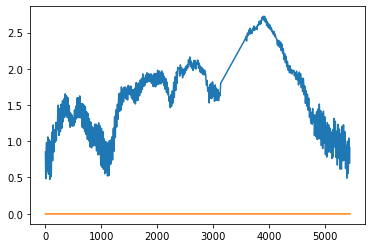

In [29]:
ytest = Y[1]
plt.plot(ytest[:,0])
plt.plot(cA3ytest[:,0])


In [ ]:
_,Y=autosplit(data_mar)
y_train,y_test = Y[0],Y[1]

def inverse_WT(cA3,cD3,cD2,cD1):
    wav=list()
    for i in range(cA3.shape[0]):
        iwave = pywt.iswt((cA3[i,:],cD3[i,:],cD2[i,:],cD1[i,:]),'db4')
        wav.append(iwave)
    return np.array(wav)
predTrain = inverse_WT(cA3ytrain,cD3ytrain,cD2ytrain,cD1ytrain)
predTest = inverse_WT(cA3ytest,cD3ytest,cD2ytest,cD1ytest)

In [ ]:
#pywt.iswt((cA3ytrain[:,0],cD3ytrain[:,0],cD2ytrain[:,0],cD1ytrain[:,0]),'db4')
cA3ytrain[0,:]

In [ ]:
predTrain.shape

In [ ]:
forecast_accuracy(predTrain,y_train,'cnn_train')

In [ ]:
plt.plot(predTrain[1,:])
plt.plot(y_train[1,:])

LSTM

In [ ]:
# LSTM Trial
X,Y=autosplit(data_cA3)
cA3ytrain,cA3ytest = run_code_editv2(build_lstm(),X,Y,batch_size)
X,Y=autosplit(data_cD3)
cD3ytrain,cD3ytest = run_code_editv2(build_lstm(),X,Y,batch_size)
X,Y=autosplit(data_cD2)
cD2ytrain,cD2ytest = run_code_editv2(build_lstm(),X,Y,batch_size)
X,Y=autosplit(data_cD1)
cD1ytrain,cD1ytest = run_code_editv2(build_lstm(),X,Y,batch_size)
_,Y=autosplit(data_mar)
y_train,y_test = Y[0],Y[1]

In [ ]:
predTrain = inverse_WT(cA3ytrain,cD3ytrain,cD2ytrain,cD1ytrain)
predTest = inverse_WT(cA3ytest,cD3ytest,cD2ytest,cD1ytest)

# Wavelet transform Trial 2

In [ ]:
data_mar[target].name 

In [ ]:
X = series.values
X = (X - X.mean())/(X.std())
std = StandardScaler().fit_transform(series.values.reshape(-1,1))

plt.plot(series.values)
plt.plot(X)
plt.plot(std,alpha=0.2)

In [ ]:
#-------------------
std_scale=False
#==================
series = data_mar[target]
name = series.name
idx = series.index
signal = series.values
if std_scale: signal = (signal - signal.mean())/(signal.std())

coeff = pywt.swt(signal,'db4',level=3)
coeff = np.array(coeff)

cA3,cD3 = coeff[0][0],coeff[0][1]
cA2,cD2 = coeff[1][0],coeff[1][1]
cA1,cD1 = coeff[2][0],coeff[2][1]
# coeff.shape

In [ ]:
dict_data = {'{}_cA3'.format(name): cA3,
            '{}_cD3'.format(name): cD3,
            '{}_cD2'.format(name): cD2,
            '{}_cD1'.format(name): cD1}
wt = pd.DataFrame(dict_data,dtype='float32',index=idx)

In [ ]:
wt.plot()

In [ ]:
plt.plot(series,label='ori')
plt.plot(cA3,label='cA3')
# plt.plot(cD3,label='cD3')
plt.plot(cA2,label='cA2')
# plt.plot(cD2,label='cD2')
plt.plot(cA1,label='cA1')
# plt.plot(cD1,label='cD1')

plt.legend()

In [ ]:
iwave = pywt.iswt((cA3,cD2,cD1),'db4')
iwave2 = pywt.iswt((cA3,cD3,cD2,cD1),'db4')
plt.plot(iwave)
plt.plot(iwave2)
plt.plot(data[target].values)
# plt.plot(series)

# Wavelet Trial

In [ ]:
trial_d = data.iloc[100:200,10:12]
trial_d
# trial_d.head()

In [ ]:
def DWT_seq_tran(signal2d):
    lv = 2
    N = np.zeros((signal2d.shape[0],signal2d.shape[1]*lv))
    for i in range(signal2d.shape[1]):
        arr = pywt.swt(signal2d[:,i],wavelet='db4',level=lv-1)
        cA,cD = arr[0][0],arr[0][1]#,arr[1][1]
        N[:,i+0] = cA
        N[:,i+1] = cD
    return N

X, y = list(), list()
t_past = 30
t_future = 1
series=trial_d.values
for window_start in range(len(series)):
    past_end = window_start + t_past
    future_end = past_end + t_future
    print(window_start)
    if future_end > len(series):
        break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    # print(past,'**', future)
    print('#',"-"*20,'#')
    past = DWT_seq_tran(past)
    # future = DWT_seq_tran(future)
    print(past,'**', future)
    print('#',"*"*20,'#')
    X.append(past)
    y.append(future)
X,y = np.array(X),np.array(y)

In [ ]:
print(X.shape)
plt.plot(X[0,:,:])
# plt.plot(N[:,i])

# plt.plot(X[0,:,1])

In [ ]:
coeff = pywt.swt(data[target],wavelet='db4',level=3) 
for i in range(3):
    plt.plot(coeff[i][0],label=i)
plt.legend()
# for i in range(3):
#     plt.plot(coeff[i][1],label=i)
# plt.legend()